In [96]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
from torch.optim import Optimizer, Adam, SGD
from torchvision import transforms, datasets
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax
from torch import optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import ImageFile

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

(1.0, 1000.0)

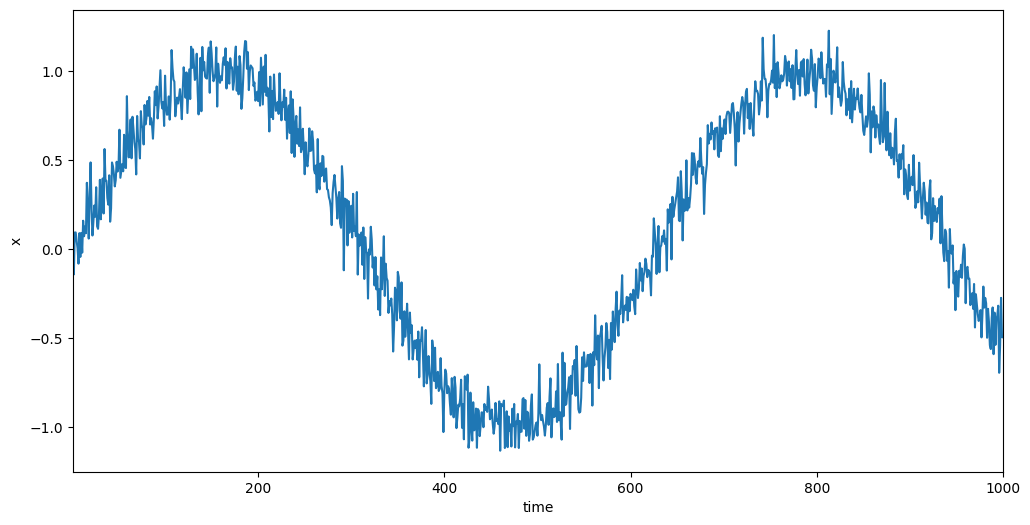

In [97]:
T = 1000
time = np.arange(1, T + 1, dtype=np.float32)
x = np.sin(0.01 * time) + np.random.normal(0, 0.1, (T,))

plt.figure(figsize=(12, 6))
plt.plot(time, x)
plt.ylabel('x')
plt.xlabel('time')
plt.xlim([1, 1000])

In [98]:
def train(net, train_loader, device, num_epochs, learning_rate):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    loss_function = nn.L1Loss()
    loss_history = []

    with tqdm(total=len(train_loader) * num_epochs, position=0, leave=True) as pbar:
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            pbar.set_description(f"Epoch: {epoch + 1}, Loss: {running_loss:.2f}")
            pbar.update()
            loss_history.append(running_loss)
    return loss_history

In [99]:
def print_loss(history):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [100]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [101]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None,
         xscale='linear', yscale='linear', fmts=('-', 'm--', 'g-.', 'r:', 'k:'), figsize=(6, 3), axes=None):
    if legend is None:
        legend = []

    plt.rcParams["figure.figsize"] = figsize
    axes = axes if axes else plt.gca()

    if (hasattr(X, "ndim") and X.ndim == 1) or (isinstance(X, list) and not hasattr(X[0], "__len__")):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif (hasattr(Y, "ndim") and Y.ndim == 1) or (isinstance(Y, list) and not hasattr(Y[0], "__len__")):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)

    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)

    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    plt.show()

In [102]:
tau = 16
features = np.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
x_train, y_train = features[:n_train], labels[:n_train]

tensor_x, tensor_y = torch.Tensor(x_train), torch.Tensor(y_train)
dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [103]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(16, 8), nn.ReLU(),
            nn.Linear(8, 4), nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.network(x)

Epoch: 50, Loss: 3.79:   3%|▎         | 50/1900 [00:03<02:07, 14.46it/s]


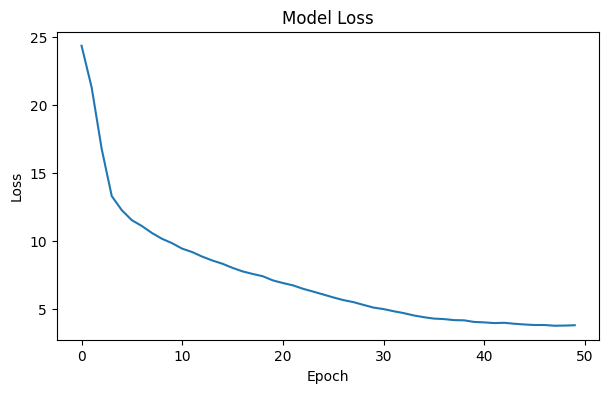

In [104]:
net_mlp = MLP().to(device)
loss_history = train(net_mlp, train_loader, device, num_epochs=50, learning_rate=0.001)
print_loss(loss_history)

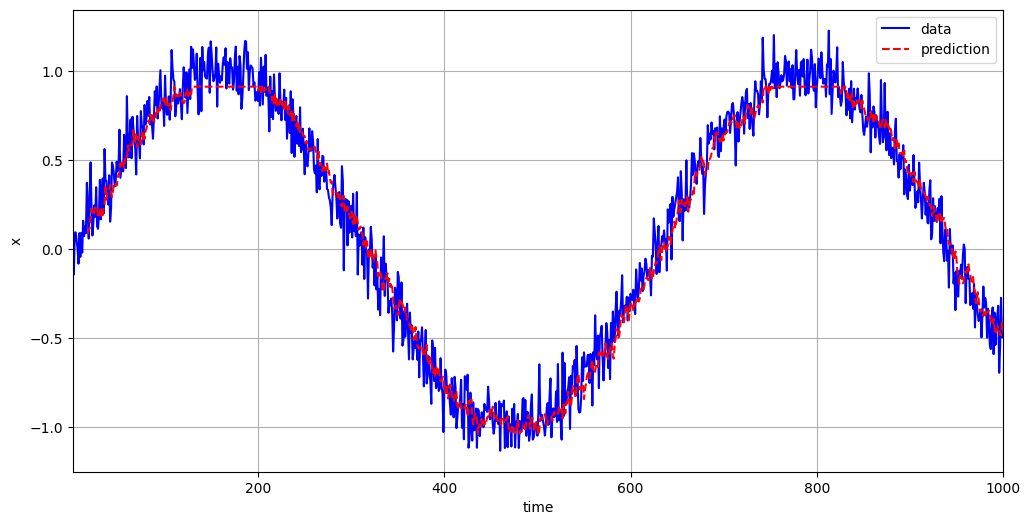

In [105]:
tensor_features = torch.Tensor(features).to(device)
onestep_preds_mlp = net_mlp(tensor_features)
plot([time, time[tau:]], [x, onestep_preds_mlp.detach().cpu().numpy()], 'time', 'x',
     legend=['data', 'prediction'], xlim=[1, 1000], figsize=(12, 6), fmts=['b-', 'r--'])

In [106]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                          batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)
        rnn_out, _ = self.rnn(x)
        return self.fc(rnn_out[:, -1, :])

Epoch: 50, Loss: 4.13:   3%|▎         | 50/1900 [00:08<05:01,  6.14it/s]


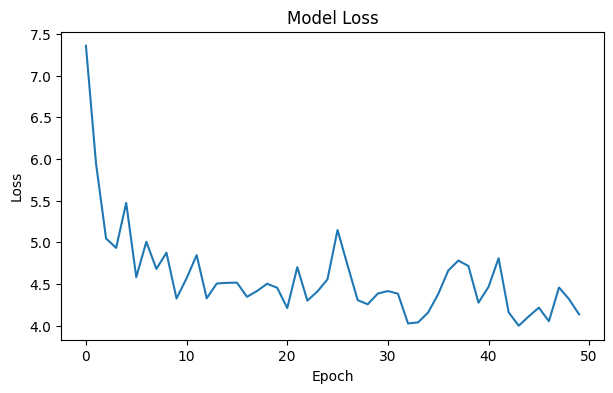

In [107]:
net_rnn = RNN(input_size=1, hidden_size=64, output_size=1, num_layers=4, dropout=0.2).to(device)
loss_history = train(net_rnn, train_loader, device, num_epochs=50, learning_rate=0.001)
print_loss(loss_history)

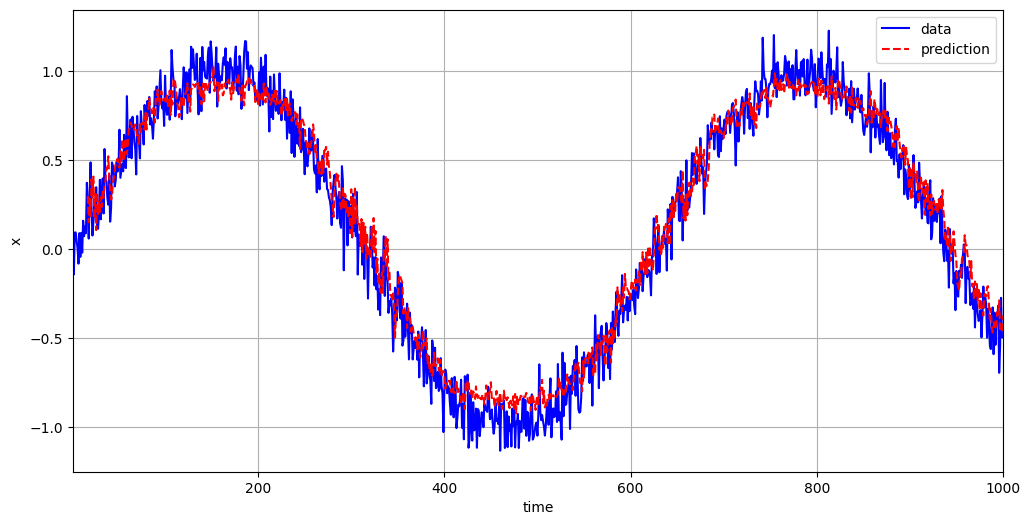

In [108]:
onestep_preds_rnn = net_rnn(tensor_features)
plot([time, time[tau:]], [x, onestep_preds_rnn.detach().cpu().numpy()], 'time', 'x',
     legend=['data', 'prediction'], xlim=[1, 1000], figsize=(12, 6), fmts=['b-', 'r--'],)

In [109]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

Epoch: 50, Loss: 3.85:   3%|▎         | 50/1900 [00:06<04:15,  7.24it/s]


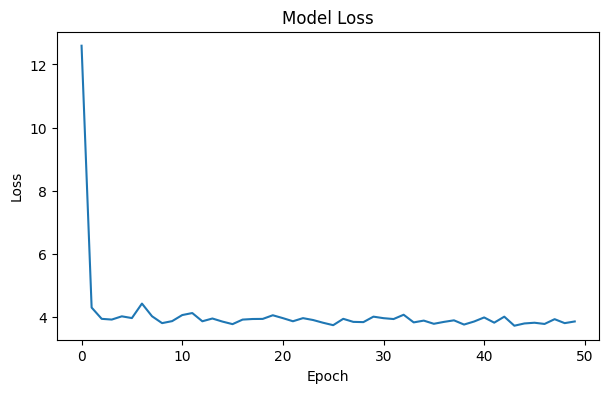

In [110]:
net_lstm = LSTM(input_size=1, hidden_size=64, output_size=1, num_layers=2, dropout=0.2).to(device)
loss_history = train(net_lstm, train_loader, device, num_epochs=50, learning_rate=0.001)
print_loss(loss_history)

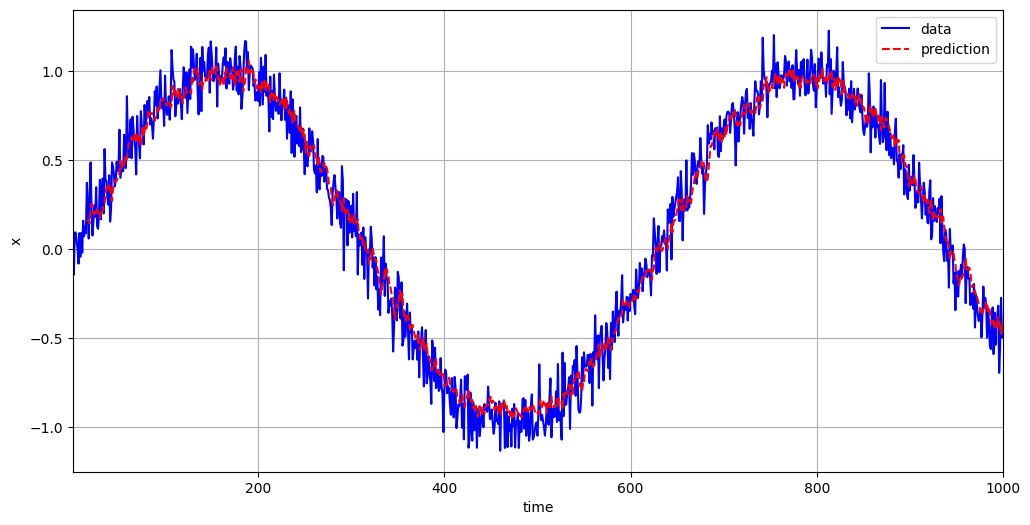

In [111]:
onestep_preds_lstm = net_lstm(tensor_features)
plot([time, time[tau:]], [x, onestep_preds_lstm.detach().cpu().numpy()], 'time', 'x',
     legend=['data', 'prediction'], xlim=[1, 1000], figsize=(12, 6), fmts=['b-', 'r--'],)